# Spam Detection

In [1]:
# Library to work with csv file
import pandas as pd

# Library for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# module to Create word clouds for spam and ham messages
from wordcloud import WordCloud

# module to split data for training and testing seperately
from sklearn.model_selection import train_test_split

# module to convert texts to matrix of vectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# modules to Train and build model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

#Library to store trained model
import pickle

# module to create pipeline
from sklearn.pipeline import Pipeline

**Importing Data**

In [2]:
data = pd.read_csv('spam.csv', encoding = 'latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
data.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN

In [5]:
data['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

**Data Analysis**

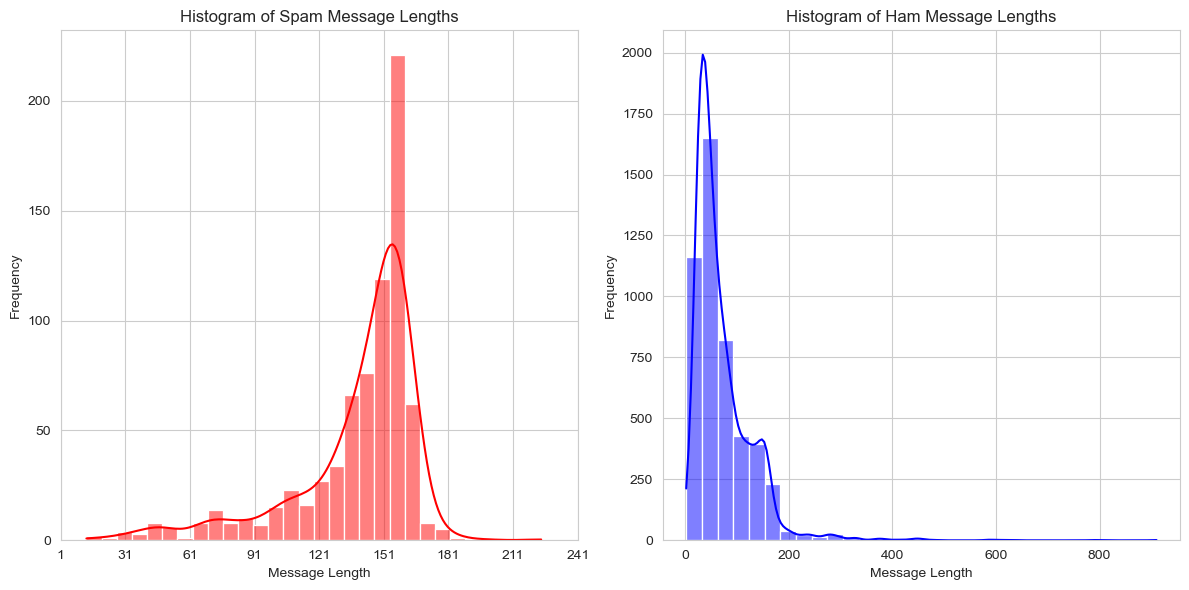

In [6]:
# Creating histogram
# Separate spam and ham data
spam_data = data[data['v1'] == 'spam']
ham_data = data[data['v1'] == 'ham']

# Set up Matplotlib and Seaborn styles
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Plot histograms of message lengths for spam and ham messages
plt.subplot(1, 2, 1)
sns.histplot(spam_data['v2'].apply(len), color='red', bins=30, kde=True)
plt.title('Histogram of Spam Message Lengths')
plt.xticks(range(1,250,30))
plt.xlabel('Message Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(ham_data['v2'].apply(len), color='blue', bins=30, kde=True)
plt.title('Histogram of Ham Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Inference:** From the above histagram, we can see that most spam message has lenght around 150 and most of the ham message falls between the length of 30 and 60

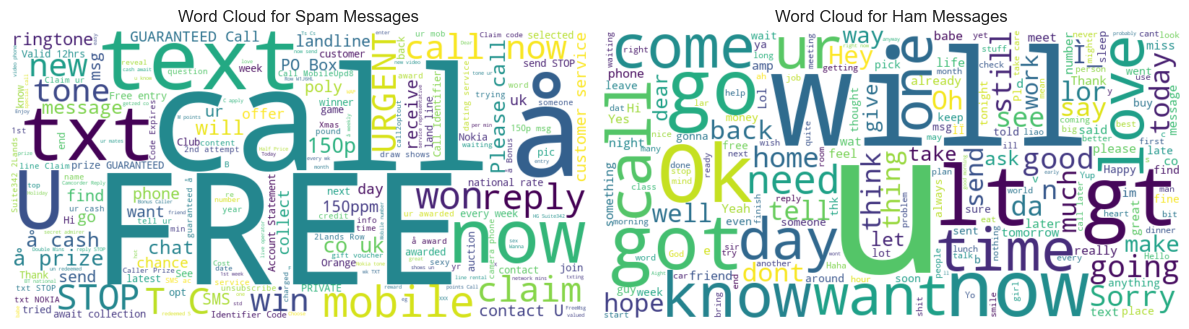

In [7]:
# most common words
spam_text = ' '.join(spam_data['v2'])
ham_text = ' '.join(ham_data['v2'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.tight_layout()
plt.show()

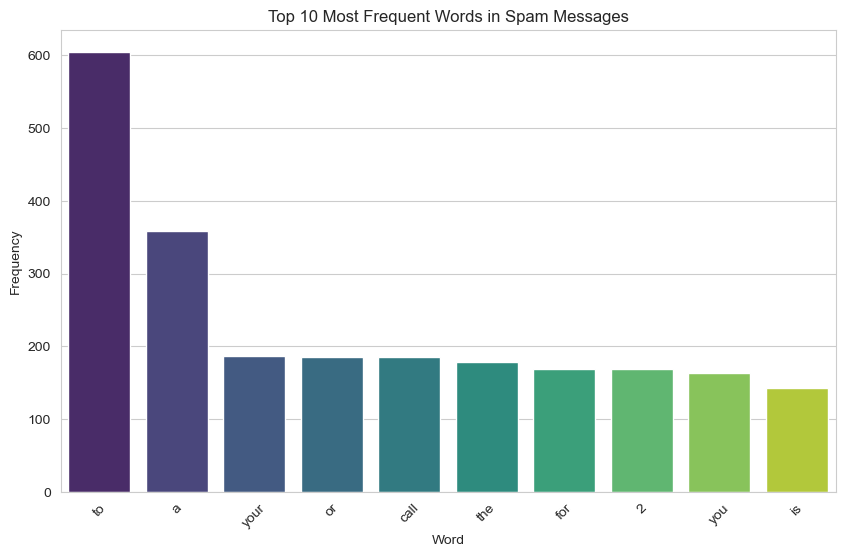

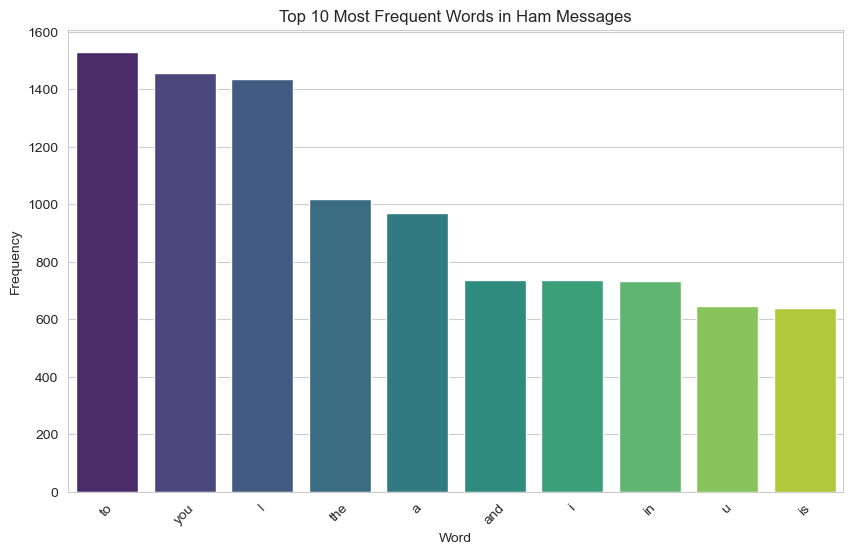

In [8]:
# word frequencies for spam and ham messages
from collections import Counter

def plot_word_frequencies(data, title):
    word_counts = Counter(data.split())
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=word_counts_df, x='Word', y='Frequency', palette='viridis')
    plt.title(title)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_word_frequencies(spam_text, 'Top 10 Most Frequent Words in Spam Messages')
plot_word_frequencies(ham_text, 'Top 10 Most Frequent Words in Ham Messages')

**Inference:** It seems most of these are stop word, so we need to process the data

**Data Preprocessing**

In [9]:
# Removing useless column
data = data.iloc[:, :2]
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
# Checking whether there is any null values
data.isna().sum()

v1    0
v2    0
dtype: int64

In [11]:
import re # for using regular expression
from nltk.corpus import stopwords  # to get stop words 
from nltk.tokenize import word_tokenize # to tokenize the words
from nltk.stem import WordNetLemmatizer # to convert the word into its base form

def preprocess_text(text):
    '''
        1. Text have been converted to lower case 
        2. Removing numbers, punctuation that are not useful for the modelling
        3. Tokenizing the word to work with removing stop words and to converting the word to root word (lemmatization)
    '''
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words to their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text

In [12]:
for index, value in enumerate(data.iloc[:,1]):
    data['v2'][index] = preprocess_text(value)

C:\Users\gokul\AppData\Local\Temp\ipykernel_24512\2702165222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['v2'][index] = preprocess_text(value)


In [ ]:
# # Save the DataFrame to a CSV file
# df.to_csv('output.csv', index=False)

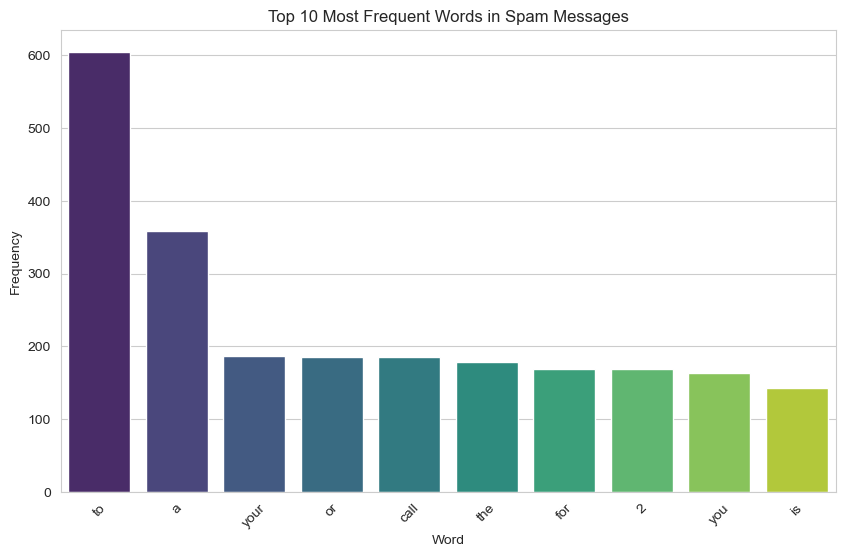

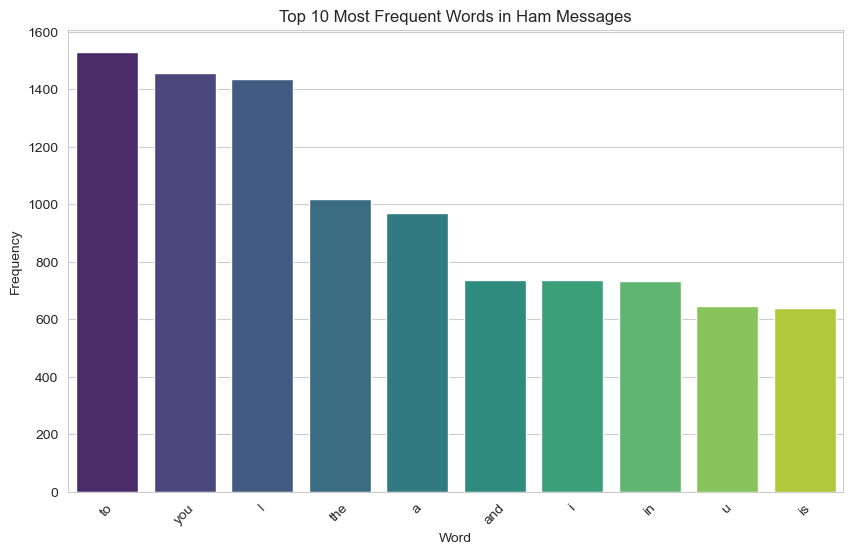

In [13]:
spam_data = data[data['v1'] == 'spam']
ham_data = data[data['v1'] == 'ham']
plot_word_frequencies(spam_text, 'Top 10 Most Frequent Words in Spam Messages')
plot_word_frequencies(ham_text, 'Top 10 Most Frequent Words in Ham Messages')

In [14]:
# Converting categorical data to number class
data['Spam']=data['v1'].apply(lambda x:1 if x=='spam' else 0)
data.head(5)

C:\Users\gokul\AppData\Local\Temp\ipykernel_24512\544781450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Spam']=data['v1'].apply(lambda x:1 if x=='spam' else 0)


,v1,v2,Spam
0,ham,go jurong point crazy available bugis n great ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry wkly comp win fa cup final tkts st ...,1
3,ham,u dun say early hor u c already say,0
4,ham,nah dont think go usf life around though,0


**Feature Extraction**

In [15]:
# Converting the text to matrix of vectors
# tfidf_vectorizer = TfidfVectorizer()
# X = tfidf_vectorizer.fit_transform(data['v2'])
# y = data['Spam']
# print(X)
X = data['v2']
y = data['Spam']

**Model Building**

In [16]:
# splitting the given data into two part, so we could use one part for training and other for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# # Multinomail Naive Bayes is best when the features follows multinomial distribution
# model = MultinomialNB()

# # training the model with x_train and y_train data
# model.fit(X_train, y_train)

**creating pipeline**

In [18]:
# Creating pipeline so that we could use easily while deployment
model_pipeline =Pipeline([
    ('vectorizer',CountVectorizer()), # using count vectorizer because it gives better f1 score than tfidf vectorizer
    ('nb',MultinomialNB())
])
# Training the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

**Model Evalution**

In [19]:
# Since it is an unbalanced dataset, we should evaluate based on f1 Score 
y_pred = model_pipeline.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[960   5]
 [ 17 133]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



**Pickle file**

In [20]:
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model_pipeline, file)